# HDA - Project 3

In [1]:
import utils
import deeplearning
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

from keras import regularizers
from keras.activations import relu
from keras.layers import Conv2D, BatchNormalization, Dropout, LeakyReLU, Flatten, Activation, Dense, MaxPooling2D, LSTM, Reshape
from keras.models import Model, Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


The following cell contains the hyper-parameters that can be tuned for code execution:
- subject: select the subject on which to test the model, between [1,4];
- folder: directory name where '.mat' files are stored;
- label_col: column of features to be selected to perform activity detection, between [0,6]:

|  Label |  Feature |
|:-:     |:-:|
|  0     | Locomotion (TASK A)  |
|  1     | High Level Activity |
|  2     | Low Level Left Arm  |
|  3     | Low Level Left Arm Object  |
|  4     | Low Level Right Arm  |
|  5     | Low Level Right Arm Object  |
|  6     | Medium Level Both Arms (TASK B2) |

- window_size: parameter that sets the length of temporal windows on which to perform the convolution;
- stride: step length to chose the next window.

The size of the temporal window seems to be fundamental in order to get a more specific and powerful model; of course the choice of the step lenght between consequent windows has to be consistent and to make sense. Thinking about a real-time situation, as long as we collect data we can use a sliding window of real-time samples; in this way, it is reasonable to use also a small value for the stride. Another important reason behind the choice of the value of the 

In [2]:
subject = 1
folder = "./data/full/"
label = 0     # default for task A
window_size = 64
stride = 3

In [3]:
[x_train, y_train, x_test, y_test, n_classes] = utils.preprocessing(subject,
                                                         folder,
                                                         label,
                                                         window_size,
                                                         stride)

Training samples:  157125 
Test samples:       57536 
Features:             110


# Hybrid Neural Network
In the following section we have implemented the neural network proposed in [1], with one block consisting of (Batch Normalization + Conv2D + MaxPool2D) followed by two layers of **LSTM**. 

Particular emphasis should be given to how we pass the output of the convolutional block to the recurrent layers; in fact, we need to appropriately reshape the output in order to make it consistent. As we know, the _convolutional power_  consists on being able to extract significant features from our input data; with the reshape procedure we merge these features in order to give them a sense of temporal dependency.

Practical example using the following problem: in our case, our samples consist of 64x110 images and we implemented 50 distinct filters in the convolutional block. So, after the conv block, our images are represented by a 27x110x50 tensor. In order to shift this in the _temporal domain_ we consider the 27 lines as temporal dependant and we represent each line as a feature vector of size 110x50. After this procedure we can feed the recurrent neural network appropriately. 

In [4]:
n_features = x_train.shape[2] #number of features taken into consideration for the solution of the problem

model_hyb = deeplearning.Hybrid((window_size,n_features,1), n_classes)
model_hyb.summary() # model visualization

model_hyb.compile(optimizer = Adam(lr=0.01), 
                   loss = "categorical_crossentropy", 
                   metrics = ["accuracy"])

input_train = x_train.reshape(x_train.shape[0], window_size, n_features, 1)
input_test = x_test.reshape(x_test.shape[0], window_size, n_features, 1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 64, 110, 1)        4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 54, 110, 50)       600       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 110, 50)       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 27, 5500)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 27, 300)           6961200   
_________________________________________________________________
lstm_2 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               154112    
__________

Just an implementation note: if we want to use the 2D convolution, we have to add to our input the _depth_ information. Only out dataset representation changes, not its size.

In [5]:
model = deeplearning.Hybrid((window_size,n_features,1), n_classes)
model.load_weights('./data/model_hyb.h5',by_name=True)

In [6]:
trainingFeatures = np.load('./data/features_training.npy')
testingFeatures = np.load('./data/features_testing.npy')
#np.load('/labels_training.npy',y_train)
#np.load('/labels_testing.npy',y_test)

In [7]:
# Reverse the one-hot encoder procedure in order to obtain the output labels
output_train = np.argmax(y_train, axis=1)
output_test = np.argmax(y_test, axis=1)
prediction_encoded = model.predict(input_test)
prediction = np.argmax(prediction_encoded, axis=1)

C = [2**(-6)]
prediction_svm = deeplearning.SVMLayer(C,
                                        output_train,
                                        trainingFeatures,
                                        testingFeatures) 

Training the model with C = 0.0156 ...


In [27]:
print(y_test)
print(np.max(prediction_encoded,axis=0))

[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]
[0.23409848 0.26939812 0.21094495 0.23268679 0.22394083]


In [8]:
print("\nBEFORE SVM:")

print("Accuracy: ", accuracy_score(output_test, prediction))
print("F1-measure: ", utils.f1_score(output_test, prediction, average='weighted'))

print("\nAFTER SVM:")
print("Accuracy: ", accuracy_score(output_test, prediction_svm))
print("F1-measure: ", utils.f1_score(output_test, prediction_svm, average='weighted'))


BEFORE SVM:
Accuracy:  0.3578848462702928
F1-measure:  0.3417542096383463

AFTER SVM:
Accuracy:  0.9039515581771677
F1-measure:  0.9037009549398655


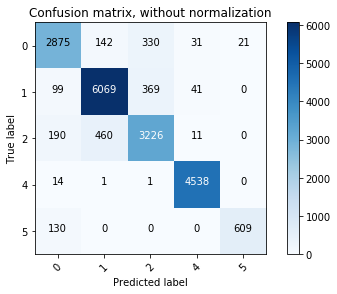

In [29]:

      
# Compute and plot confusion matrix
cnf_matrix = utils.confusion_matrix(output_test, prediction_svm)
np.set_printoptions(precision=2)

plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1,2,4,5],
                      title='Confusion matrix, without normalization')